<a href="https://colab.research.google.com/github/Noahlie07/Stock-Price-Forecasting-with-Long-Short-Term-Memory-Neural-Network/blob/main/Stock_Forecasting_Model_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Part I: Data Loading and Preprocessing**

I began by importing the CSV file through pandas. Since we will only be taking the closing price of the stock as our sole factor, I dropped all features except for Date and Closing Price

            Date        Open        High         Low       Close   Adj Close  \
0     1997-05-15    0.121875    0.125000    0.096354    0.097917    0.097917   
1     1997-05-16    0.098438    0.098958    0.085417    0.086458    0.086458   
2     1997-05-19    0.088021    0.088542    0.081250    0.085417    0.085417   
3     1997-05-20    0.086458    0.087500    0.081771    0.081771    0.081771   
4     1997-05-21    0.081771    0.082292    0.068750    0.071354    0.071354   
...          ...         ...         ...         ...         ...         ...   
6511  2023-03-30  101.550003  103.040001  101.010002  102.000000  102.000000   
6512  2023-03-31  102.160004  103.489998  101.949997  103.290001  103.290001   
6513  2023-04-03  102.300003  103.290001  101.430000  102.410004  102.410004   
6514  2023-04-04  102.750000  104.199997  102.110001  103.949997  103.949997   
6515  2023-04-05  103.910004  103.910004  100.750000  101.099998  101.099998   

          Volume  
0     1443120000  
1

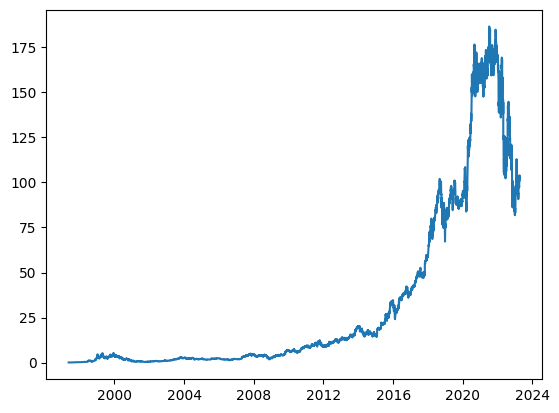

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv('/content/drive/MyDrive/AMZN.csv')
print(data)

data = data[["Date", "Close"]]
data['Date'] = pd.to_datetime(data['Date']) ## convert date column from string to actual date datatype
plt.plot(data["Date"], data["Close"])
plt.show() # Stock we will be working with

I then prepared the dataset for sequencing. The reason for this is LSTM takes data in sequences to generate prediction.

In [4]:
def shift_dataframe(df, n_steps):
    # Create a copy of the dataframe to avoid modifying the input
    df = df.copy()

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i) # shifts values of the whole column backward in time by i positions

    df.dropna(inplace=True)
    # remove rows with missing values which were created by the shifting operation
    # therefore first entry will be the seventh day

    return df


lookback = 7 # Sequential data later will be in packs of seven days
shifted_df = shift_dataframe(data, lookback)
print(shifted_df)

                 Close  Close(t-1)  Close(t-2)  Close(t-3)  Close(t-4)  \
Date                                                                     
1997-05-27    0.079167    0.075000    0.069792    0.071354    0.081771   
1997-05-28    0.076563    0.079167    0.075000    0.069792    0.071354   
1997-05-29    0.075260    0.076563    0.079167    0.075000    0.069792   
1997-05-30    0.075000    0.075260    0.076563    0.079167    0.075000   
1997-06-02    0.075521    0.075000    0.075260    0.076563    0.079167   
...                ...         ...         ...         ...         ...   
2023-03-30  102.000000  100.250000   97.239998   98.040001   98.129997   
2023-03-31  103.290001  102.000000  100.250000   97.239998   98.040001   
2023-04-03  102.410004  103.290001  102.000000  100.250000   97.239998   
2023-04-04  103.949997  102.410004  103.290001  102.000000  100.250000   
2023-04-05  101.099998  103.949997  102.410004  103.290001  102.000000   

            Close(t-5)  Close(t-6)  C

Scaled stock prices via Min-Max Scaling.

In [5]:
# convert to numpy and scale closing price from -1 to 1
shifted_df_np = shifted_df.to_numpy()
scaler = MinMaxScaler((-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

# differentiating training features and predicted feature
X = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0] # first column is date
X = np.flip(X, axis=1).copy()
# Original order is from Close(t-1) to Close(t-7), whereas we want the oldest data/day to come first

**Train-Test Splitting**  
Split data 95% - 5% because the data we are dealing with is quite large. Did it via simple indexing.

In [6]:
train_test_split_index = int(len(X) * 0.95)
X_train = X[:train_test_split_index]
X_test = X[train_test_split_index:]
y_train = y[:train_test_split_index]
y_test = y[train_test_split_index:]

I then proceeded with shaping the dataset to fit the LSTM model.  
- Input Data expected by LSTM model should be in the dimension (batch_size, sequence_length, num_features).  
- LSTM also expects target output to be in the dimension (batch_size, output_size). Output_size is 1 as in the Closing Price feature.

In [7]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Converting to Tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

**Batching**  
Since the dataset is huge, I will be splitting them into mini-batches for training to be more efficient.

Data is converted into "Dataset" object type in order for it to be accepted into the DataLoader.

In [8]:
class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

training_dataset = Dataset(X_train, y_train)
testing_dataset = Dataset(X_test, y_test)

Feeding dataset into DataLoader for batching.

In [9]:
batch_size = 16 # Customizable
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
# Randomizes order to prevent overfitting/overspecialization of model to the training data
# Weight updates will no longer be biased towards recent trends in batch sequence
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)
# train_loader and test_loader - Dataloaders - are basically iterators that will help us load the batches during training and testing

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # For those who have a GPU - I personally did not have a GPU but this code is here to help anyone who has a GPU and is running my code themselves run it faster

### **Part II: LSTM Architecture**

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_nodes, num_of_layers):
        super().__init__()
        self.hidden_size = hidden_nodes
        self.num_stacked_layers = num_of_layers

        self.lstm = nn.LSTM(input_size, hidden_nodes, num_of_layers,
                            batch_first=True) # Emphasize LSTM will be taking in batches

        self.fc = nn.Linear(hidden_nodes, 1) # map hidden layer to final output of only one feature (Closing price to be predicted)

    def forward(self, x):
        batch_size = x.size(0)
        # h0 and c0 are the hidden state (short-term memory) and cell state (long-term memory) respectively
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        # Initialized to 0 at the start of each sequence as we don't want memory of previous sequences to influence present sequence
        out, _ = self.lstm(x, (h0, c0)) # Pass training features into LSTM
        out = self.fc(out[:, -1, :])  # Selects the last timestep's hidden state (short-term memory) which is the prediction
        return out

model = LSTM(1, 4, 1) # 4 nodes per layer and 1 layer only. Found this to be the best settings.
model.to(device) # Load model to GPU if available

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

I found that 4 nodes per layer and only 1 layer in the hidden layer provided the best result.

### **Part III: Training the Model**

Defining Loss Function, Optimizer, and the learning rate and num of epochs.

In [12]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss() # Mean-Squared Loss - standard loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Training Function** - standard training procedure where weights are updated after every batch. Reports average error across batches every 100 batches (just for us to see if model is improving)

In [13]:
def train_one_epoch():
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) # loads batch into GPU if available

        output = model(x_batch) # generate output prediction
        loss = loss_function(output, y_batch) # compares output prediction to actual value
        running_loss += loss.item()

        optimizer.zero_grad() # resets gradients of previous cycle
        loss.backward() # computes gradient of loss with respect to all parameters
        optimizer.step() # moves weights towards opposite of gradient direction (gradient descent)

        if batch_index % 100 == 99:  # every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            print() #newline
            running_loss = 0.0

**Validation Function** - Purpose is to test the model on unseen data after every epoch trained. Unseen data used here will just be the testing dataset.

In [14]:
def validate_one_epoch():
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print()

Run training and testing for specified number of epochs.

In [15]:
for epoch in range(num_epochs):
    model.train(True)
    train_one_epoch()
    model.train(False) # so that weights won't be updated during validation
    validate_one_epoch()
    print("------------------")

Epoch: 1
Batch 100, Loss: 0.445

Batch 200, Loss: 0.149

Batch 300, Loss: 0.078

Val Loss: 0.096

------------------
Epoch: 2
Batch 100, Loss: 0.016

Batch 200, Loss: 0.009

Batch 300, Loss: 0.006

Val Loss: 0.015

------------------
Epoch: 3
Batch 100, Loss: 0.004

Batch 200, Loss: 0.003

Batch 300, Loss: 0.002

Val Loss: 0.009

------------------
Epoch: 4
Batch 100, Loss: 0.002

Batch 200, Loss: 0.002

Batch 300, Loss: 0.001

Val Loss: 0.006

------------------
Epoch: 5
Batch 100, Loss: 0.001

Batch 200, Loss: 0.001

Batch 300, Loss: 0.001

Val Loss: 0.006

------------------
Epoch: 6
Batch 100, Loss: 0.001

Batch 200, Loss: 0.001

Batch 300, Loss: 0.001

Val Loss: 0.005

------------------
Epoch: 7
Batch 100, Loss: 0.001

Batch 200, Loss: 0.001

Batch 300, Loss: 0.001

Val Loss: 0.005

------------------
Epoch: 8
Batch 100, Loss: 0.001

Batch 200, Loss: 0.001

Batch 300, Loss: 0.001

Val Loss: 0.005

------------------
Epoch: 9
Batch 100, Loss: 0.000

Batch 200, Loss: 0.000

Batch 3

### **Part IV: Generate Predictions and Results**

In [16]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten() # .detach() to remove all calculated gradients during training

**Inverse Scaling**  
Inverse Scaling generated predictions and actual values to original scale for comparison and graphing purposes.  
The scaler's .inverse_transform() function **only works on objects of the same dimension as that it is fitted on**. Therefore, we create dummy arrays that have the same dimensions as the previous arrays fitted into the scaler, and then conduct inverse scaling.

In [17]:
# our initiated MinMaxScaler only recognizes the original dimension we fitted it in,
# that being (rows - num of samples, col - Close, Close(t-1), ..., Close(t-7))
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dummies[:, 0].copy()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

y_test = dummies[:, 0].copy()

<ipython-input-17-1e1cc4db91e0>:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


**Graphing**

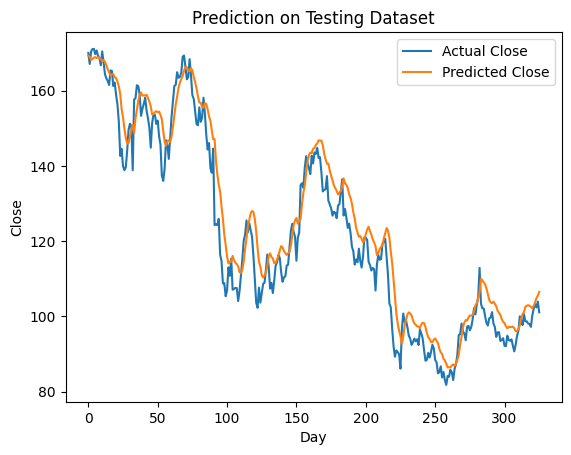

In [18]:
plt.plot(y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on Testing Dataset')
plt.legend()
plt.show()

**Checking model accuracy**

The Root-Mean-Squared-Error of this project is less than 25% of the stock's actual volatility. The R-squared is above 0.9, close to 1, therefore indicating that the model has solid predictive power.

In [21]:
# Generating error scores of predictions generated
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, test_predictions)

print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Std dev of y_test: {np.std(y_test):.4f}")
print(f"R-squared: {r2:.4f}")
# r2 = 1 - (Sum of Squared Residuals / Total Sum of Squares)
# For those who don't know,
# SSR is the sum of the difference between predicted and actual value squared
# TSS is the sum of the difference between actual value and mean value

Root Mean Squared Error: 6.7447
Std dev of y_test: 25.5163
R-squared: 0.9301


### **Things I did to try improve accuracy**

- Experimentation on **Sequence Length**
- Experimentation on Different **train-test split ratios**
- **Hidden nodes, num. of hidden layers** tuning
- Experimentation on different **batch sizes**
- Experimentation on number of **epochs and learning rates**  
I found the current setting on these parameters to yield the best value. Feel free to try different parameter values yourself.